## This is my attempt at implementing the SLANG algorithm

importing

In [6]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.linalg as alg
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
#from tqdm import tqdm

EPS = 1e-5  # define a small constant for numerical stability control

### Class defined

In [7]:
class SLANG_GaussianNetwork(nn.Module):
    def __init__(self, layer_sizes, inital_prior_std = 0.1, inital_prior_mean = 0.0, alpha = 0.1, beta = 0.9,
                 sqrt_width_scaling=False, device=None, dtype=None, minibatch_size = 1, error = 1e-12, rank_approx = 4, noise = 1, decay = 0.51, decay_start = 100):
        
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(SLANG_GaussianNetwork, self).__init__()
        
        # Store network dimensions and other parameters
        self.layer_sizes = layer_sizes  # dimension of network layer input 
        self.dim_in = layer_sizes[0] 
        self.dim_out = layer_sizes[-1]

        self.num_params = sum(dim_in * dim_out + dim_out for dim_in, dim_out in zip(layer_sizes[:-1], layer_sizes[1:])) # number of parameters
        
        self.decay = decay
        self.decay_start = decay_start
        self.alpha = alpha
        self.beta = beta
        self.minibatch_size = minibatch_size 
        self.error = error
        self.rank_approx = rank_approx
        self.noise = noise
        self.prior_std = inital_prior_std
        # prior parameters are registered as buffers so they can be alteared  
        self.register_buffer('prior_means', torch.ones(self.num_params, **factory_kwargs)*inital_prior_mean)

        # prior covariance matrix
        prior_cov = torch.diag(torch.ones(self.num_params, **factory_kwargs)*inital_prior_std)
        # prior variance scales as 1/dim_in
        if sqrt_width_scaling:  
            prior_cov /= self.dim_in ** 0.5
        
        self.means = torch.ones(self.num_params, requires_grad=True)*inital_prior_mean
        #self.cov = torch.diag(torch.ones(self.num_params, requires_grad=True, dtype=torch.float64)*inital_prior_std)*1.0
        self.presision = torch.eye(self.num_params, dtype=torch.float64)*1/inital_prior_std
        

    
    def ___dia_inv___(self, D, is_float = True):
        '''the inveres of a 2D diagonal matrix'''
        if is_float:
            d = torch.zeros((self.num_params, self.num_params))
        else:
            d = torch.zeros((self.num_params, self.num_params), dtype=torch.cfloat)
        
        for i in range(self.num_params):
            d[i,i] = torch.inverse(D[i:i+1,i:i+1])
        return d


    def ___fast_inverse___(self, g, U, D, L):
        D_inv = self.___dia_inv___(D) # D^{-1}
        I_L = torch.eye(L) # I size L
        U = U.to(D_inv.dtype) # quick fix
        U_Td_invU = torch.t(U) @ D_inv @ U # U^T.D^{-1}.U
        A = alg.inv(I_L + U_Td_invU) # A = (I_L + U^T.D^{-1}.U)^{-1}

        UAU_T = U @ A @ torch.t(U) # U.A.U^T
        D_inv_g = D_inv @ g # D^{-1}.g
        y = D_inv_g - D_inv @ UAU_T @ D_inv_g  # D^{-1}.g - D^{-1}.U^T.A.U.D^{-1}.g

        return y

    
    def ___sample___(self,mean, U, D):
        eps = torch.normal(0,1,size = (self.num_params, 1))
        pse = 1e-6 * torch.eye(self.num_params)
        return mean + torch.squeeze(alg.cholesky(torch.inverse(D + U @ torch.t(U)) + pse) @ eps)

    def ___diamul___(self, D, vec):
        d = torch.zeros((self.num_params, self.num_params), dtype=torch.cfloat)
        for i in range(self.num_params):
            d[i,i] = D[i,i]*vec[i]
        return d

    


    def ___fast_sample___(self, mean, U, D, L):
        '''since covarance matrix approx is equal to (D + UU^T)^{-1} the squar root of (D + UU^T)^{-1} gives us what we need for the 
        reparametivation trick we obtain this by using Woodbury matrix identity'''
        eps = torch.normal(0,1,size = (self.num_params, 1))

        D_inv_root = self.___dia_inv___(D.to(torch.cfloat)**(1/2), is_float = False) # D^(-1/2)
        
        V = D_inv_root @ (U.to(torch.cfloat)) # V = D^(-1/2) U
        
        # Woodbury matrix identity
        invert = torch.inverse(torch.eye(L) + torch.t(V) @ V)
        IL_VVT = torch.eye(self.num_params) - V @ invert @ torch.t(V) 
        
        #L, Q = alg.eig(IL_VVT)
        #Sig_root = self.___diamul___(D_inv_root, L) @ torch.t(Q)
        Sig_root = D_inv_root @ alg.cholesky(IL_VVT)     # symmertic parametisation is a real matrix
        Sig_root_eps = torch.real(Sig_root) @ eps 
        #print('theta', mean + torch.squeeze(Sig_root_eps) )
        return mean + torch.squeeze(Sig_root_eps) 

    def ___minibatch___(self, M, N, data):
        if M == N:
            return data
        p = torch.ones(N)/N
        index = p.multinomial(num_samples=M)
        return data[index]

    def ___diag___(self, U):
        diag = []
        for i in range(self.num_params):
            diag.append(torch.t(U[i,:]) @ U[i,:])
        return torch.tensor(diag)

    def ___conditional___(self, D, U, D_p, U_p):
        current_approx = D + U @ torch.t(U)
        pevious_approx = D_p + U_p @ torch.t(U_p)
        
        return alg.matrix_norm(current_approx - pevious_approx) < self.error

    def SLANG(self, data, stop = 2):
        # Initializing
        L = self.rank_approx
        mean = self.means
        u = np.zeros((self.num_params, L))
        for i in range(L):
            u[i][L-i-1] = 1/self.prior_std
        U = torch.tensor(u, requires_grad=True, dtype=float)
        D = self.presision

        # previous U and D
        U_p = torch.zeros((self.num_params, L), requires_grad=True) 
        D_p = torch.zeros((self.num_params, self.num_params), requires_grad=True)

        lamb = 1/self.prior_std * torch.ones(self.num_params)
        alpha = self.alpha
        beta = self.beta
        M = self.minibatch_size
        N = data.shape[0]
        counter = 0 
        iter = 0
        while counter < stop:
            
            if self.___conditional___(D, U, D_p, U_p):
                counter += 1 
            else:
                counter = 0
            
            # generatind a sample from  θ_t ∼ N (θ|µ_t, (U_tU_t^T + D_t)^-1).
            theta = self.___fast_sample___(mean, U, D, L)    # self.___sample___(mean, U, D)

            # sample a minibatch
            data_M = self.___minibatch___(M,N, data)

            # backprop
            g = self.___backprop_goodfellow___(M, data_M, theta) #, D + U @ torch.t(U), mean_p, D_p + U_p @ torch.t(U_p))

            # getting the the matrix Q_{1:L}\Lamda_{1:L}^{1/2}
            G_hat = N/M*sum([g[:,i:i+1] @ torch.t(g[:,i:i+1]) for i in range(M)])
            A = (1 - beta)*(U @ torch.t(U)) + beta*G_hat # are approximation is herman 
            V = self.___fast_eig___(A, L) 

            grad_d = (1 - beta) * (U**2).sum(dim=1) + beta * (g**2).sum(dim=1) - (V**2).sum(dim=1)

            # updating U and D
            U_p = U 
            D_p = D
            
            U = V
            D = torch.diag((1 - beta)*torch.diagonal(D) + grad_d + beta*lamb)
            #torch.diag(self.___diag___(U) + beta*torch.diagonal(G_hat) + (1 - beta)*torch.diagonal(D) + beta*lamb - self.___diag___(V))
            
            #

            # caculating 
            mu_lamb = torch.zeros(self.num_params)
            for i in range(self.num_params):
                mu_lamb += lamb[i]*mean[i]
            g_hat = sum([g[:,i] for i in range(M)]) + mu_lamb
            grad_mean = self.___fast_inverse___(g_hat, U, D, L)
            mean = mean - alpha*grad_mean

            if iter >= self.decay_start:
                alpha = alpha*self.decay
                beta = beta*self.decay
            else:
                iter += 1
            
            current_approx = D + U @ torch.t(U)
            pevious_approx = D_p + U_p @ torch.t(U_p)
            print('error', alg.matrix_norm(current_approx - pevious_approx).detach().numpy())
            #print('mean, cov',mean,torch.inverse(D + U @ torch.t(U)))
            #print('D, U',D, U)

        cov = torch.inverse(D + U @ torch.t(U))
        self.cov = cov
        self.means = mean
        return mean, cov

    def get_network(self):
        return (self.means, self.cov)

    def ___Q_from_qr___(self, A):
        Q, _ = alg.qr(A)
        return Q

    def ___nystrom___(self, U, Q, anorm):
        """
        Use the Nystrom method to obtain approximations to the
        eigenvalues and eigenvectors of A (shifting A on the subspace
        spanned by the columns of Q in order to make the shifted A be
        positive definite).
        """
        
        def ___svd_thin_matrix___(A):
            """
            Efficient implementation of SVD on [N x D] matrix, D >> N.
            """
            (e, V) = alg.eigh(A @ A.t())
            
            Sigma = torch.sqrt(e)
            SigInv = 1/Sigma 
            SigInv[torch.isnan(SigInv)] = 0
            U = A.t() @ (V * SigInv)
            
            return U, Sigma, V
            
        anorm = .1e-6 * anorm * math.sqrt(1. * self.num_params)
        E = U @ Q + anorm * Q
        R = Q.t() @ E
        R = (R + R.t()) / 2
        R = alg.cholesky(R, upper=False) # Cholesky
        tmp = alg.solve(R, E.t()) # Solve
        V, d, _ = ___svd_thin_matrix___(tmp)
        d = d * d - anorm
        return d, V

    # Alot of this this copped 
    def ___fast_eig___(self, A, L, n_iter = 8): # ?
        # From Finding Structure with Randomness: Probabilistic Algorithms for Constructing Approximate Matrix Decompositi page 35 see usefull reading
        # and based on the Github https://github.com/aaronpmishkin/SLANG 
        K = L + 2
        Q = 2*(torch.rand((self.num_params, K), device= A.device, dtype= A.dtype)-0.5)
        for _ in range(max(0, n_iter-1)):
            Q = self.___Q_from_qr___(A @ Q)
        
        oldQ = Q
        
        Q = A @ Q
        anorm = torch.max(torch.norm(Q, dim=0)/torch.norm(oldQ, dim=0))
        Q = self.___Q_from_qr___(Q)
        
        d, V = self.___nystrom___(A, Q, anorm)

        # Retain only the entries with the k greatest absolute values
        _, idx = torch.abs(d).sort()
        idx = idx[:L]
        #print(alg.matrix_rank(V[:, idx]), d[idx])
        
        ret = V[:, idx] @ torch.diag(abs(d[idx])**0.5)
        return ret.to(A.dtype)

    
    def forward(self, input, sampled_params):
        # Forward pass using the sampled parameters
        start = 0
        for i, (dim_in, dim_out) in enumerate(zip(self.layer_sizes[:-1], self.layer_sizes[1:])):
            end = start + dim_out * dim_in
            weight = sampled_params[start:end].view(dim_out, dim_in)
            start = end
            end = start + dim_out
            bias = sampled_params[start:end]
            start = end
            input = F.linear(input, weight, bias)
            if i < len(self.layer_sizes) - 2:
                input = F.relu(input)
        return input  
    
    def ___backprop_goodfellow___(self, M, data_M, theta):#, cov, mean_p, cov_p):
        theta.retain_grad()
        g = torch.zeros((self.num_params, M))
        for i in range(M):
            # forward pass
            pred = self.forward(data_M[i, :1], theta)
            # backward pass with the log likelihood i.e. logp(Di|θt)
            pred.backward(-1/(self.noise**2) * (data_M[i, 1:] - pred), retain_graph=True)
            g[:,i] += theta.grad
            theta.grad.zero_() # zero the gradients for the next sample
            
        return g
    


### Testing

In [3]:
net = SLANG_GaussianNetwork([1,5,1], alpha = 0.9, beta = 0.9,
                             inital_prior_std = 10,  rank_approx = 2,  
                             minibatch_size = 5, decay = 0.51, decay_start = 40, error = 1e-7)
data = torch.tensor([[0.01, 0.02], [1.5, 3.0], [1.2, 2.8], [5.05, 10.3], [1.6, 2.9], [1.5, 3.2], [1.3, 3.0]],   
                     requires_grad=True)


# Compute the cov wrt the sampled network parameters
mean, Sig = net.SLANG(data)
print('mean', mean)
print('cov', Sig)

error 2706719.241269909
error 2437629.8135682223
error 256114.72647759467
error 25605.177804232593
error 2569.7350483705914
error 358.14266300753
error 264.87888010830636
error 162.41077759910672
error 988.6953493901651
error 113527305.74027342
error 2214465582.781065
error 211311743.73649445
error 19497933.235290274
error 8632268.417504594
error 10769939.879329363
error 39001139.10088704
error 6197880.436075251
error 53131326.15307643
error 16856826.591917515
error 63711087.21878761
error 2061097582.3644614
error 206109694.96865273
error 2085476820.683949
error 208003455.64220747
error 56799363.61229747
error 56311966.59692011
error 2096467052.3809206
error 1935519953.5873182
error 179898073.8080742
error 45721515.96762416
error 5860531.5598681625
error 17180445.95202518
error 23802659.352833528
error 2016491124.2567255
error 1829934378.491888
error 1907682135.4550729
error 1918533582.3241768
error 191082392.27894384
error 11990126.407499637
error 21215678.377390083
error 2049464608.3

### Regression Ground Truth & Dataset

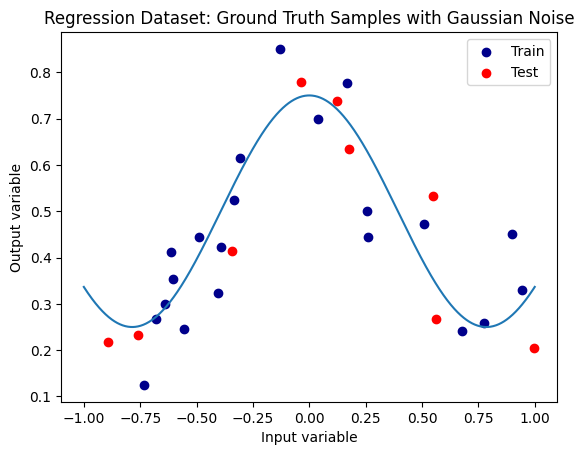

In [4]:
def unnormalised_ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return np.cos(x*4)/4 + 0.5#10 + 15*np.cos(0.1/(0.05*(x+1)+0.02)) + 3*np.exp(0.5*np.sin(((50*(x+1))**0.9-3)/5))/((50*(x+1)+0.01)**(-0.5)) - 12.5*(x+1)**2

def normalised_ground_truth(xs):
    ys = unnormalised_ground_truth(xs)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s

def generate_dataset(size=75, noise=0.1, split=0.3):
    xs = np.linspace(-1, 1, 1000)
    ys = unnormalised_ground_truth(xs)
    samp_ind = np.random.randint(0, 999, size)
    x_samps = xs[samp_ind]
    y_samps = ys[samp_ind] + np.random.normal(0, noise, size)
    return train_test_split(x_samps, y_samps, test_size=split, random_state=13)


xs = np.linspace(-1, 1, 1000)
ys = unnormalised_ground_truth(xs)
x_tr, x_te, y_tr, y_te = generate_dataset(size=30)

plt.title("Regression Dataset: Ground Truth Samples with Gaussian Noise")
plt.plot(xs, ys)
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
data_tr = []
for i in range(len(x_tr)):
    data_tr.append([x_tr[i], y_tr[i]])

data_te = []
for i in range(len(x_te)):
    data_te.append([x_te[i], y_te[i]])


data_tr = torch.FloatTensor(data_tr).unsqueeze(-1)
data_te = torch.FloatTensor(data_te).unsqueeze(-1)



### Training

In [5]:
net = SLANG_GaussianNetwork([1,2,2,1], alpha = 0.9, beta = 0.9,
                             inital_prior_std=10,  rank_approx = 3,  
                             minibatch_size = 10, decay=0.9, decay_start=30, error = 1e-7)



mean, cov = net.SLANG(data_tr)
print('mean', mean)
print('cov', cov)


error 127.40064334615
error 4411548.468545345
error 3970393.5203530947
error 402595.7249562731
error 71977.27451619887
error 7202.821339923241
error 802.7468892824955
error 62076.06891233788
error 55926.85367285993
error 5592.692683225484
error 559.2103061241902
error 163303.96421007247
error 146980.1378424623
error 14697.752070008657
error 1469.669936473986
error 139.05507748674108
error 47.04055484992409
error 212936.86689910473
error 7394145.35179169
error 4035175.2175926883
error 1821360.922357829
error 4375559.275001169
error 10898254.034067368
error 6233733.634104159
error 1651880.784494951
error 1410302.2459998156
error 2270779.6558804996
error 450167.4869713206
error 3025555.1586129344
error 1539411.6801318186
error 103533.64097472858
error 3427558.8418656182
error 619865.1184461119
error 921722.9821686628
error 3318763.8687368375
error 3158740.9026410193
error 2814500.6427214486
error 751016.9141421578
error 266188.2689065268
error 658580.4722677496
error 333400.25072484475
er

C:\Users\james\AppData\Local\Temp\ipykernel_1076\678323407.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


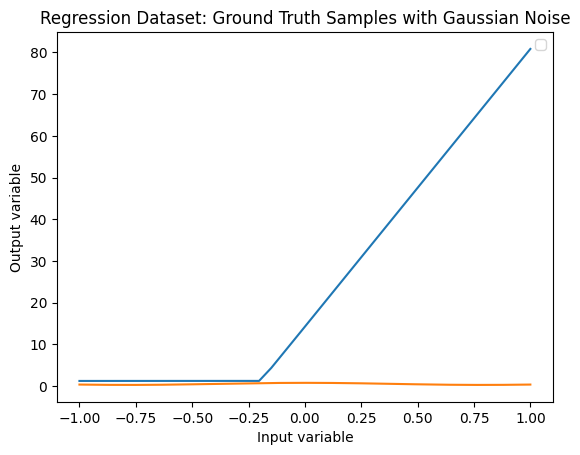

In [8]:
plt.title("Regression Dataset: Ground Truth Samples with Gaussian Noise")
#print(data_tr[:,0].squeeze(-1).detach().numpy())
#print(net.forward(data_tr[:,1], mean).squeeze(-1).detach().numpy())
d = [net.forward(torch.tensor([x]), mean.to(float)).detach().numpy() for x in xs]
plt.plot(xs, d)
plt.plot(xs, ys)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()